In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
%matplotlib inline  

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import nltk
    from nltk.tokenize import RegexpTokenizer
    from nltk.stem.wordnet import WordNetLemmatizer
    from nltk.corpus import stopwords
    from nltk import FreqDist

    import gensim
    from gensim import corpora, models, similarities
    import pyLDAvis
    import pyLDAvis.gensim

/home/sam/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/home/sam/anaconda3/envs/insight/lib/python3.7/site-packages/funcy/colls.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable, Iterator, defaultdict
/home/sam/anaconda3/envs/insight/lib/python3.7/site-packages/funcy/colls.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable, Iterator, defaultdict
/home/sam/anaconda3/envs/insight/lib/python3.7/site-packages/funcy/flow.py:2: DeprecationWarning: Using or importing the ABCs fro

In [2]:
cities = pd.read_csv('cities_geo2_df.csv', index_col=0)

# Reset index
cities = cities.reset_index()
cities.drop(['index'], axis=1, inplace=True)

In [3]:
cities.head()

,Country,City,Understand,Get in,Get around,See,Do,Buy,Eat,Sleep,...,Stay safe,Get out,City_alternative,Lat,Lon,Alt,City_alternative2,Latitude,Longitude,AccentCity
0,Afghanistan,Herat,Herat is the second largest city in Afghanista...,The Herat International Airport is situated 15...,NaN,"Ghala Ekhteyaradin, Takht Safar, Bagh Milat, ...",Take a shower in the huge subterranean Hammams.,There are several antique shops on the north ...,Herat has a mixture of traditional and modern ...,"Budget[edit] Mowafaq Hotel, northeast corner ...",...,Herat is one of the safer cities in Afghanista...,Chisht-i-Sharif is some 177 km from Herat city...,Herat,34.340000,62.189999,927.0,NaN,NaN,NaN,NaN
1,Afghanistan,Kabul,Kabul is a very historic city of the region th...,By plane[edit] Kabul International Airport (IA...,Maps of Kabul are available from Afghanistan I...,Bagh-e Babur (Gardens of Babur). The gardens ...,Kabul Wall. A pleasant hike with rewarding vi...,The Share-e Naw area has some shops. The Kab...,The once thriving restaurant scene in Kabul ha...,"Kabul is not a cheap place to stay, principall...",...,Kabul is generally considered one of the safer...,Most expats take any opportunity they can to l...,Kabul,34.516667,69.183334,1808.0,NaN,NaN,NaN,NaN
2,Afghanistan,Jalalabad,NaN,Jalalabad is on the major highway that links K...,NaN,The large reservoir near Sarobi. This is loca...,Go fishing along the river side. Go swimming .,Handi Craft Handicraft is one of most famous ...,Pakora go for special “Pakora” Food in Hindu ...,The government hotel Spingar is on the easter...,...,NaN,This article is an outline and needs more co...,Jalalabad,34.420000,70.449997,573.0,NaN,NaN,NaN,NaN
3,Afghanistan,Kandahar,Kandahār or Qandahār (Pashto: کندهار ) (Persia...,By plane[edit] Kandahar International Airport ...,NaN,"Kandahar Museum, (Western end of the Eidgah ...",NaN,"Afghanistan International Bank (AIB), Kabul Ba...","There are plenty of food choices in Kandahar, ...","Budget[edit] Armani Hotel, (Two miles from c...",...,"As of 2013, the city centre of Kandahar is qui...",Kabul Helmand Harat Zabul Spin Boldak (Spin Bu...,Kandahar,31.610000,65.699997,1015.0,NaN,NaN,NaN,NaN
4,Afghanistan,Kunduz,NaN,Most visitors will arrive by road from Pol-e K...,"The city is fairly small. The local roads, li...",There's not much for tourists here.,NaN,NaN,The usual Afghan fare - kebab or lamb with ric...,NaN,...,NaN,This article is an outline and needs more ...,Konduz,36.720000,68.860001,394.0,NaN,NaN,NaN,NaN


In [4]:
# Run once
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

In [5]:
tokenizer = RegexpTokenizer(r'\w+') # retains alphanumeric character
lmtzr = WordNetLemmatizer()
cached_stop_words = stopwords.words("english")

In [6]:
def lemmatize_dropstop_words(text): 
    return [lmtzr.lemmatize(word) for word in text if (lmtzr.lemmatize(word) not in cached_stop_words) and (len(word)>2)]

def remove_num(text): 
    return re.sub("\d+", " ", text)

In [7]:
cities = cities.replace(np.nan, '', regex=True)

In [8]:
# Add my stop words from txt file
my_stop_words = np.genfromtxt('my_stop_words.txt',dtype='str', delimiter=', ').tolist()
cached_stop_words.extend(my_stop_words)

# Tokenize, lemmatize
cities['See_tokens'] = cities['See'].str.lower().apply(remove_num).apply(tokenizer.tokenize).apply(lemmatize_dropstop_words)
cities['Do_tokens'] = cities['Do'].str.lower().apply(remove_num).apply(tokenizer.tokenize).apply(lemmatize_dropstop_words)

In [9]:
# Pool tokens
def pool_tokens(row):
    return row['See_tokens']+row['Do_tokens']

cities['Pooled_tokens'] = cities.apply(pool_tokens, axis=1)

In [10]:
# Most common words
words = []
for sublist in cities['Pooled_tokens']:
    for item in sublist:
        words.append(item)
        
fdist = FreqDist(words)
fdist.most_common(20)

[('museum', 10744),
 ('park', 8853),
 ('art', 5080),
 ('tour', 4498),
 ('temple', 3988),
 ('free', 3827),
 ('old', 3588),
 ('festival', 3400),
 ('local', 3337),
 ('well', 3333),
 ('center', 3190),
 ('bus', 3132),
 ('town', 3095),
 ('church', 3057),
 ('world', 3036),
 ('beach', 3027),
 ('garden', 2985),
 ('road', 2960),
 ('river', 2874),
 ('walk', 2792)]

In [11]:
# NLP

# Create dictionaries of unique words in the processed tokenized text
Pooled_dict = corpora.Dictionary(cities['Pooled_tokens'])

In [12]:
# Filter extreme values
Pooled_dict.filter_extremes(no_below=15)#, no_above=0.5)

In [13]:
# Convert texts to vectors
Pooled_corpus = [Pooled_dict.doc2bow(text) for text in cities['Pooled_tokens']]

In [14]:
# LDA
Pooled_lda = gensim.models.ldamodel.LdaModel(corpus=Pooled_corpus,
                                               id2word=Pooled_dict,
                                               num_topics=50, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=1000,
                                               passes=1,
                                               alpha='auto',
                                               eta='auto')

# Visualize LDA results
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(Pooled_lda, Pooled_corpus, Pooled_dict)
vis

/home/sam/anaconda3/envs/insight/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
47    -0.057021  0.030688       1        1  17.377148
17    -0.035303 -0.015465       2        1  12.583822
34    -0.037637  0.022278       3        1   9.456694
22     0.014935 -0.051117       4        1   8.567306
43    -0.080598 -0.004468       5        1   7.305493
1      0.046297 -0.005866       6        1   7.249354
6      0.016218 -0.094145       7        1   5.730206
20    -0.021769 -0.013161       8        1   5.607368
2     -0.029494  0.051715       9        1   3.411204
46    -0.034462 -0.075825      10        1   2.942423
21     0.121393 -0.022780      11        1   2.751678
8      0.039018  0.000342      12        1   2.692493
44    -0.108898  0.004443      13        1   1.783788
48    -0.037727  0.005089      14        1   1.441148
28     0.003097 -0.022892      15        1   1.216034
24     0.007465 -0.026075      16        1   1.210197
36     0.024803  0.030891      17        1   1.183313
18    -0.013478  0.006267      18        1   0.981282
9     -0.057522 -0.041693      19        1   0.897647
0      0.001363 -0.011507      20        1   0.750232
27    -0.019979  0.019827      21        1   0.748882
13    -0.008220 -0.035027      22        1   0.590408
15    -0.059526 -0.016059      23        1   0.487600
4     -0.019191  0.000266      24        1   0.414630
19    -0.007649 -0.015587      25        1   0.355133
11     0.007667  0.014858      26        1   0.276981
30    -0.005410  0.004455      27        1   0.244568
5      0.040426 -0.000975      28        1   0.229650
16     0.042184 -0.022103      29        1   0.172571
26    -0.024334  0.010400      30        1   0.171080
3      0.000281  0.051792      31        1   0.156514
33     0.021405  0.034255      32        1   0.149502
31     0.013980  0.005789      33        1   0.121598
7      0.022472  0.012012      34        1   0.115067
49     0.016871 -0.005079      35        1   0.083727
14     0.018781  0.012377      36        1   0.081314
25    -0.016133  0.020992      37        1   0.071824
37     0.014117  0.012013      38        1   0.062921
12     0.013911 -0.005513      39        1   0.049509
23     0.038297  0.011178      40        1   0.044292
32     0.012092  0.029556      41        1   0.035008
35     0.012411 -0.003938      42        1   0.034772
40    -0.005623  0.001640      43        1   0.031476
41     0.043927  0.011027      44        1   0.030742
45     0.021468  0.013101      45        1   0.024125
39     0.010117  0.007394      46        1   0.023114
42     0.010226  0.011608      47        1   0.020158
29     0.002932  0.006818      48        1   0.015178
10     0.020822  0.024732      49        1   0.013144
38     0.020997  0.021473      50        1   0.005682, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
3089  Default  3704.000000      temple  3704.000000  30.0000  30.0000
487   Default  5399.000000         art  5399.000000  29.0000  29.0000
878   Default  4391.000000        tour  4391.000000  28.0000  28.0000
499   Default  2933.000000       beach  2933.000000  27.0000  27.0000
41    Default  4022.000000        free  4022.000000  26.0000  26.0000
86    Default  3426.000000         old  3426.000000  25.0000  25.0000
627   Default  3311.000000    festival  3311.000000  24.0000  24.0000
937   Default  2379.000000      church  2379.000000  23.0000  23.0000
67    Default  3393.000000       local  3393.000000  22.0000  22.0000
385   Default  3268.000000        well  3268.000000  21.0000  21.0000
129   Default  3055.000000        town  3055.000000  20.0000  20.0000
104   Default  3078.000000        road  3078.000000  19.0000  19.0000
14    Default  3665.000000      center  3665.000000  18.0000  18.0000
525   Default  2314.000000         bus  2314.000000  17.0000  17.0000
331   Default  2755.000000   

In [15]:
# Save cities with final index
cities.to_csv('cities_text_processed_df.csv')

In [16]:
# Recommendation

# Create vectors that represent topic distribution of each lyric or comment
Pooled_topic_vectors = Pooled_lda[Pooled_corpus]

In [17]:
# Search cities
cities[cities['City'] == 'New York City']

,Country,City,Understand,Get in,Get around,See,Do,Buy,Eat,Sleep,...,Lat,Lon,Alt,City_alternative2,Latitude,Longitude,AccentCity,See_tokens,Do_tokens,Pooled_tokens
2527,United States,New York City,New York City is one of the global hubs of int...,By plane[edit] IATA: NYC is the code for all N...,"Main article: New York City/Get around‎ ""...","Like most of the great world cities, New York ...",A general word of advice on sightseeing in New...,New York is arguably the fashion capital of th...,"New York has, as you might expect of the Big A...",The costs of hotel accommodation in New York C...,...,40.714269,-74.005974,2,,,,,"[great, world, new, york, abundance, great, at...","[general, word, advice, sightseeing, new, york...","[great, world, new, york, abundance, great, at..."


In [18]:
input_city = 2527

In [19]:
Pooled_sims = []
for i in np.arange(len(Pooled_topic_vectors)):
    sim = gensim.matutils.cossim(Pooled_topic_vectors[input_city], Pooled_topic_vectors[i])
    Pooled_sims.append(sim)
cities['Similarity to input'] = Pooled_sims

In [20]:
cities.sort_values(by=['Similarity to input'], ascending = False).head(10)

,Country,City,Understand,Get in,Get around,See,Do,Buy,Eat,Sleep,...,Lon,Alt,City_alternative2,Latitude,Longitude,AccentCity,See_tokens,Do_tokens,Pooled_tokens,Similarity to input
2527,United States,New York City,New York City is one of the global hubs of int...,By plane[edit] IATA: NYC is the code for all N...,"Main article: New York City/Get around‎ ""...","Like most of the great world cities, New York ...",A general word of advice on sightseeing in New...,New York is arguably the fashion capital of th...,"New York has, as you might expect of the Big A...",The costs of hotel accommodation in New York C...,...,-74.005974,2,,,,,"[great, world, new, york, abundance, great, at...","[general, word, advice, sightseeing, new, york...","[great, world, new, york, abundance, great, at...",0.999997
2509,United States,Lubbock,History[edit] Buddy Holly Charles Hardin H...,"By air[edit] Southwest Airlines, United Expres...",By car[edit] Lubbock is developed along a larg...,Lubbock is one of those rare cities where hist...,"Festivals[edit] Texans love a good party, and ...",,"Homestyle[edit] Cotton Patch Cafe, 6810 Sli...","Best Western Lubbock Windsor Inn, 5410 Inters...",...,-101.855164,976,,,,,"[lubbock, rare, history, permeates, everything...","[festival, texan, love, good, party, lubbockit...","[lubbock, rare, history, permeates, everything...",0.969698
2549,United States,Pittsburgh,"History[edit] The first European to ""discover""...",By plane[edit] Pittsburgh International Airpor...,Pittsburgh is often difficult for strangers to...,See the Districts articles for more listings. ...,See the Districts articles for more listings. ...,See the Districts articles for more listings. ...,See the Districts articles for individual list...,See the Districts articles for more listings. ...,...,-79.995888,235,,,,,"[district, article, listing, museum, pittsburg...","[district, article, listing, thing, pittsburgh...","[district, article, listing, museum, pittsburg...",0.968935
2386,United Kingdom,York,"York was known as Eboracum by the Romans, who ...",By car[edit] Although York is not directly on ...,By foot[edit] The roads within the old city (i...,"York Minster, ☎ +44 1904 557216, [1]. M-Sa 09...","Walk around the city walls, [16]. Daily 8AM-s...",York comes highly recommended for its unique s...,"Budget[edit] For budget eating, try any tradit...",Hotel rates in York tend to be more expensive ...,...,-1.083333,14,,,,,"[york, minster, largest, gothic, cathedral, no...","[walk, wall, daily, sunset, best, vantage, poi...","[york, minster, largest, gothic, cathedral, no...",0.968903
1670,Netherlands,Leiden,"A population of just over 100,000, and just un...",By train[edit] Leiden is best reached by train...,Everything is easily reached on foot and the c...,Museums[edit] Leiden is one of the most import...,There are two wonderful ways to stroll the old...,Haarlemmerstraat and Breestraat are the main s...,Leiden has a lot of restaurants and bars. Espe...,Stochemhoeve Camping [45] This is a family man...,...,4.493056,-1,,,,,"[museum, leiden, important, museum, netherland...","[wonderful, way, stroll, old, centre, leiden, ...","[museum, leiden, important, museum, netherland...",0.965634
2300,United Kingdom,Derry,The city's name is a point of political disput...,By plane[edit] City of Derry Airport [4] (airp...,Derry is essentially split (by the River Foyle...,As well as excellent tours around the city and...,City walls[edit] Derry is the only remaining c...,Most of Derry's retail stores are situated wel...,"NB: If visiting on a Monday or Tuesday, a lot ...","Budget[edit] The Merchant's House, 16 Queen St...",...,-1.500000,67,,,,,"[well, excellent, tour, wall, derry, boast, nu...","[wall, derry, remaining, completely, intact, w...","[well, excellent, tour, wall, derry, boast, nu...",0.960099
2493,United States,Kansas City,Kansas City is a city that tends to hide itsel...,By plane[edit] Kansas City International Airpo...,The national map companies produce b

In [89]:
# Calculating all pairwise cosine similarities
# ~10 hours to run
RERUN = False

if RERUN == True:
    cosims_df = pd.DataFrame()

    start_time = time.time()
    for i in np.arange((len(Pooled_topic_vectors))):
        print(i)
        clear_output(wait=True)
        j_list = []
        for num in np.arange(i):
            j_list.append(cosims_df.iloc[i,num])
        for j in np.arange(i,(len(Pooled_topic_vectors))):
            sim = gensim.matutils.cossim(Pooled_topic_vectors[i], Pooled_topic_vectors[j])
            j_list.append(sim)
        cosims_df = pd.concat([cosims_df,pd.Series(j_list)],axis=1)

    elapsed_time = time.time() - start_time
    print(elapsed_time)
    cosims_df.columns=(np.arange(len(cosims_df)))
    cosims_df.to_csv('data/cos_sims.csv')
    cosims_stacked = cosims_df.stack() 
    cosims_stacked.to_csv('data/cos_sims_stacked.csv') # Save a stacked version that can be put on SQL server
else:
    cosims_df = pd.read_csv('data/cos_sims.csv', index_col = 0)


In [22]:
cosims_df.shape

(2671, 2671)

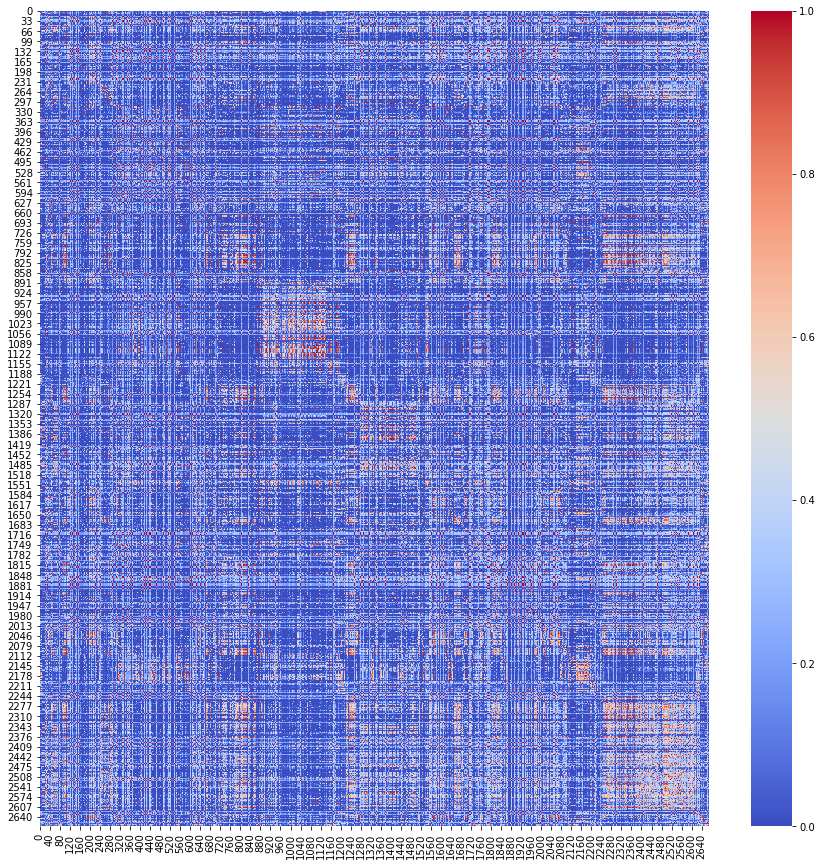

In [23]:
plt.figure(figsize=[15,15])
sns.heatmap(cosims_df, cmap='coolwarm')

In [24]:
# TF-IDF

In [25]:
# # TF-IDF
# tfidf = models.TfidfModel(Pooled_corpus)
# Pooled_corpus_tfidf = tfidf[Pooled_corpus]

In [26]:
# # TF-IDF LDA
# Pooled_tfidf_lda = gensim.models.ldamodel.LdaModel(corpus=Pooled_corpus_tfidf,
#                                                id2word=Pooled_dict,
#                                                num_topics=50, 
#                                                random_state=100,
#                                                update_every=1,
#                                                chunksize=1000,
#                                                passes=1,
#                                                alpha='auto',
#                                                eta='auto')

# # Visualize LDA results
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(Pooled_tfidf_lda, Pooled_corpus_tfidf, Pooled_dict)
# vis

In [27]:
# # TF-IDF recs
# Pooled_tfidf_topic_vectors = Pooled_tfidf_lda[Pooled_corpus_tfidf]

# Pooled_sims = []
# for i in np.arange(len(Pooled_tfidf_topic_vectors)):
#     sim = gensim.matutils.cossim(Pooled_tfidf_topic_vectors[input_city], Pooled_tfidf_topic_vectors[i])
#     Pooled_sims.append(sim)
# cities['Similarity to input'] = Pooled_sims

In [28]:
# cities.sort_values(by=['Similarity to input'], ascending = False).head(10)